# AirBnB Guest Arrival Prediction

This notebook explores data preprocessing, decision tree modeling, and custom impurity metric implementation for predicting guest booking cancellations and analyzing stay durations.

## Problem Description

For a tourism-based country like Nepal, hospitality is a major source of income. The given data represents booking information made by foreign customers via AirBnB for the year 2018. The goal is to use this data to predict whether the customer will cancel the booking or not.

### Import Libraries

- **Import essential libraries** for data manipulation, visualization, and modeling
- Set a random seed for reproducibility
- Suppress warnings for cleaner output
- These imports are foundational for all subsequent analysis

In [2]:
import pandas as pd
import numpy as np
RANDOM_STATE = 7
np.random.seed(RANDOM_STATE)

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load and Preview Dataset

- **Load the dataset** from a remote CSV file using pandas
- **Preview the first few rows** to confirm successful loading and inspect the data structure
- This step ensures the data is ready for further analysis

In [3]:
data_url = 'https://drive.google.com/uc?id=1Gqk7mPLeXlx7mo8iQZM0TpcNmnyFa-LD'
data = pd.read_csv(data_url,index_col = 0 )
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,net_booking_cancelled
0,Resort Hotel,0,342,2015,July,27,1,0,0,NaN,...,3,No Deposit,NaN,0,Transient,0.0,0,0,2.0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,BB,...,4,No Deposit,NaN,0,Transient,0.0,0,0,2.0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,BB,...,0,No Deposit,NaN,0,Transient,75.0,0,0,1.0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,NaN,...,0,No Deposit,304.0,0,Transient,75.0,0,0,1.0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,BB,...,0,No Deposit,240.0,0,Transient,98.0,0,1,2.0,0


## Dataset Description 

The given dataset is a modification of [Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191) collected by **Nuano et al.** and is available under [Creative Commons 4.0](https://creativecommons.org/licenses/by/4.0/). The dataset has a total of 26 columns and 119390 rows. Each row of the dataset represents a booking made by the client. The description of each column of the dataset is presented below. 

### Columns info

* **hotel** - Type of hotel resort or city.
* **is_canceled** - The label column. This indicates whether the guests canceled their booking or they checked-in
* **lead_time** - Number of days that elapsed between the entering date of the booking into the PMS and the arrival date.
* **arrival_date_year** - The year of the arrival date.
* **arrival_date_month** - Month of arrival date with 12 categories: “January” to “December” expressed in numbers. 1 indicates January, and 12 indicates December. 
* **arrival_date_week_number** - Week number of the arrival date.
* **arrival_date_day_of_month** - Day of the month of the arrival date.
* **stays_in_weekend_nights** - Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel.
* **stays_in_week_nights** - Number of weeknights (Monday to Friday) the guest stayed or booked to stay at the hotel.
* **meal** - Type of meal booked. 
* **country** - Country of origin. Categories are represented in the ISO 3155–3:2013 format.
* **market_segment** - Market segment designation. In categories, the term "TA" means "Travel Agents" and "TO" means "Tour Operators".
* **distribution_channel** - Booking distribution channel. The term "TA" means "Travel Agents" and "TO" means "Tour Operators".
* **is_repeated_guest** - Value indicating if the booking name was from a repeated guest (1) or not (0).
* **reserved_room_type** - Code of room type reserved. 
* **assigned_room_type** - Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g., overbooking) or by customer request.
* **booking_changes** - Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
* **deposit_type** - Indication on if the customer made a deposit to guarantee the booking.
* **agent** - ID of the travel agency that made the booking.
* **days_in_waiting_list** - Number of days the booking was in the waiting list before it was confirmed to the customer. 
* **customer_type** - Type of booking. One of Contract, Group, Transient, and Transient-party.
* **adr** - Average Daily Rate.
* **required_car_parking_spaces** - Number of car parking spaces required by the customer.
* **total_of_special_requests** - Number of special requests made by the customer (e.g. twin bed or high floor)
* **total_guests** - Total number of guests(includes adults, children, and babies).
* **net_booking_cancelled** - A difference between the total number of the previous booking canceled and the previous booking not canceled prior to this booking. A positive value means that most of the previous bookings were not canceled by the customer.

### Feature Engineering Overview

- **Review each feature** for relevance and data quality
- Prepare for preprocessing and modeling

### Inspect Dataset Structure

- **Display dataset information** including column types and non-null counts
- Helps identify categorical/numerical features and missing values
- Ensures understanding of the dataset's structure before preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   hotel                        119390 non-null  object 
 1   is_canceled                  119390 non-null  int64  
 2   lead_time                    119390 non-null  int64  
 3   arrival_date_year            119390 non-null  int64  
 4   arrival_date_month           119390 non-null  object 
 5   arrival_date_week_number     119390 non-null  int64  
 6   arrival_date_day_of_month    119390 non-null  int64  
 7   stays_in_weekend_nights      119390 non-null  int64  
 8   stays_in_week_nights         119390 non-null  int64  
 9   meal                         107451 non-null  object 
 10  country                      118902 non-null  object 
 11  market_segment               119390 non-null  object 
 12  distribution_channel         107451 non-null  object 
 13  is_r

### Analyze Missing Values

- **Calculate the percentage of missing values** for each column
- Identify features that require imputation or cleaning
- Guides the next steps in data preprocessing

In [5]:
dataset_null=(data.isna().sum()/len(data))*100.0
dataset_null_ratio=dataset_null.drop(dataset_null[dataset_null==0].index).sort_values(ascending=False)
print(dataset_null_ratio)

agent                   13.686238
meal                    10.000000
assigned_room_type      10.000000
distribution_channel    10.000000
country                  0.408744
total_guests             0.003350
dtype: float64


### Remove Rows with Missing Guest Counts

- **Drop rows** where the `total_guests` column has missing values
- Ensures all records have valid guest counts for accurate modeling
- Reduces the risk of errors in downstream analysis

In [6]:
data.dropna(subset=['total_guests'], inplace=True)

### Impute Missing Country Values

- **Fill missing values** in the `country` column with the most frequent value (`PRT`)
- Maintains data consistency and avoids dropping valuable records
- Ensures all rows have a valid country code

<Axes: xlabel='country'>

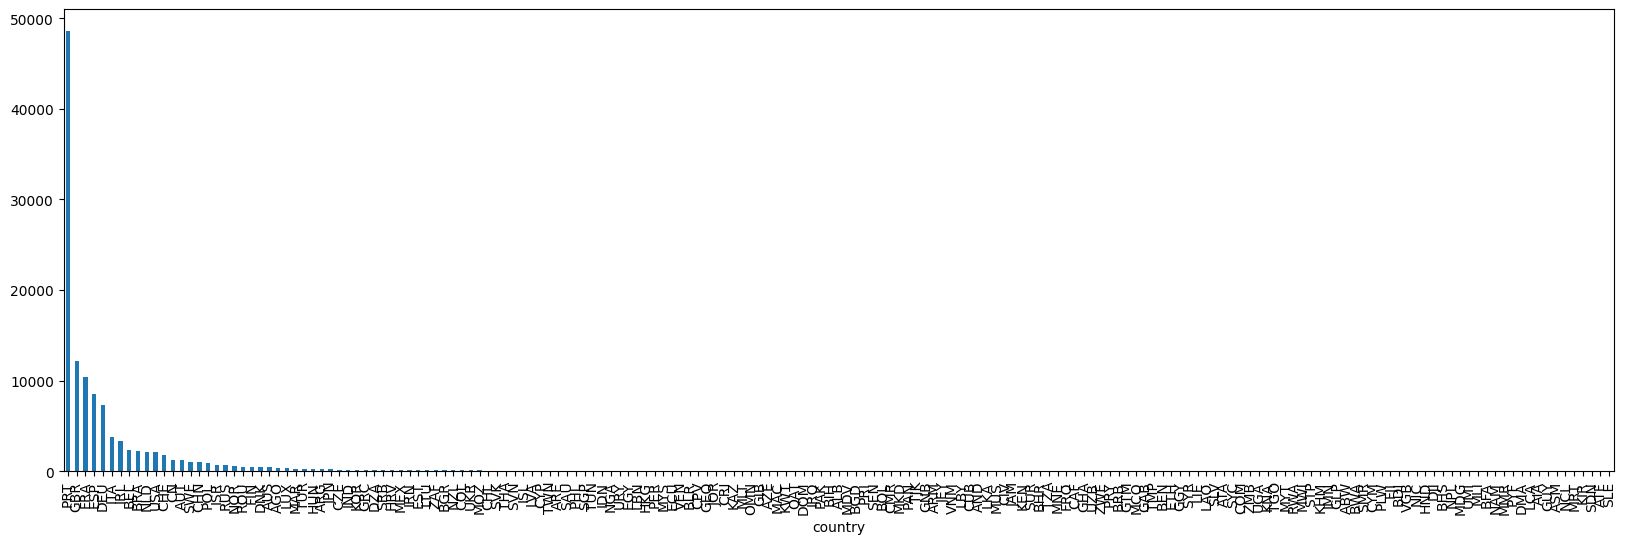

In [7]:
data['country'].value_counts().plot(kind='bar', figsize=(20, 6))

We can see that most of the rows in the `country` column have the value `PRT`. We can use `PRT` to fill in the missing value.

In [8]:
data['country'].fillna('PRT', inplace=True)

### Impute Missing Meal Values

- **Fill missing values** in the `meal` column with the mode (`BB`)
- Ensures all records have a valid meal type
- Prevents issues during model training due to missing categories

<Axes: xlabel='meal'>

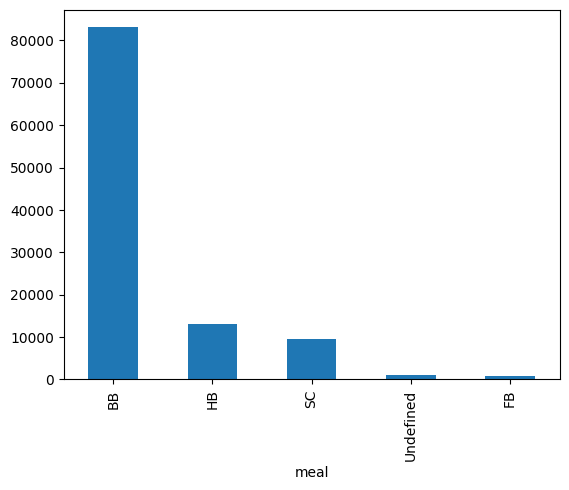

In [9]:
data['meal'].value_counts().plot(kind='bar')

In [10]:
data['meal'].fillna('BB', inplace=True)

### Impute Remaining Missing Values

- **Fill missing values** in `distribution_channel`, `agent`, and `assigned_room_type` with their respective modes
- Ensures all features are complete and suitable for modeling
- Maintains dataset integrity for further analysis

In [11]:
data['distribution_channel'].fillna(data['distribution_channel'].mode()[0], inplace=True)
data['agent'].fillna(data['agent'].mode()[0], inplace=True)
data['assigned_room_type'].fillna(data['assigned_room_type'].mode()[0], inplace=True)

### Encoding Categorical Features

- **Identify object-type columns** for encoding
- Use `LabelEncoder` to convert these to numerical values for model compatibility

In [12]:
from sklearn.preprocessing import LabelEncoder
cat_vars = [var for var in data.columns if data[var].dtypes=='O']
for column in cat_vars:
    data[column]= LabelEncoder().fit_transform(data[column])

### 🔍 Validation Step
- Check that all categorical columns have been successfully encoded as numeric values

In [13]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,net_booking_cancelled
0,1,0,342,2015,5,27,1,0,0,0,...,3,0,9.0,0,2,0.0,0,0,2.0,0
1,1,0,737,2015,5,27,1,0,0,0,...,4,0,9.0,0,2,0.0,0,0,2.0,0
2,1,0,7,2015,5,27,1,0,1,0,...,0,0,9.0,0,2,75.0,0,0,1.0,0
3,1,0,13,2015,5,27,1,0,1,0,...,0,0,304.0,0,2,75.0,0,0,1.0,0
4,1,0,14,2015,5,27,1,0,2,0,...,0,0,240.0,0,2,98.0,0,1,2.0,0


### Preview Encoded Data

- **Display the first few rows** of the encoded dataset
- Confirms that all features are now numeric and ready for modeling

In [14]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,net_booking_cancelled
0,1,0,342,2015,5,27,1,0,0,0,...,3,0,9.0,0,2,0.0,0,0,2.0,0
1,1,0,737,2015,5,27,1,0,0,0,...,4,0,9.0,0,2,0.0,0,0,2.0,0
2,1,0,7,2015,5,27,1,0,1,0,...,0,0,9.0,0,2,75.0,0,0,1.0,0
3,1,0,13,2015,5,27,1,0,1,0,...,0,0,304.0,0,2,75.0,0,0,1.0,0
4,1,0,14,2015,5,27,1,0,2,0,...,0,0,240.0,0,2,98.0,0,1,2.0,0


### Visualize Label Distribution

- **Plot the distribution** of the target variable `is_canceled`
- Reveals class imbalance, which is important for model evaluation and metric selection

<Axes: xlabel='is_canceled'>

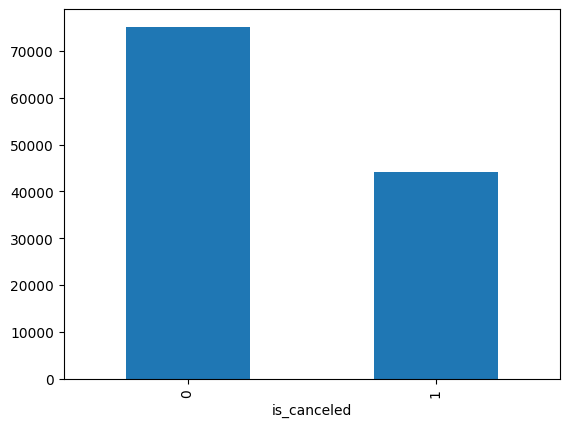

In [15]:
data['is_canceled'].value_counts().plot(kind='bar')

### Split Dataset into Train and Test Sets

- **Divide the data** into training and testing sets (80/20 split)
- Use stratified sampling to maintain class proportions
- Prepares data for model training and unbiased evaluation

In [16]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['is_canceled'])
y = data['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state = RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95508, 25), (23878, 25), (95508,), (23878,))

### Train Decision Tree Classifier

- **Initialize and train** a decision tree classifier on the training data
- Set a fixed random state for reproducibility
- This step builds the predictive model for guest cancellation

In [17]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=7)

### Evaluate Model Performance

- **Make predictions** on both training and test sets
- **Calculate the weighted F1 score** to assess model accuracy, considering class imbalance
- Provides insight into model fit and potential overfitting

In [18]:
from sklearn.metrics import f1_score
y_pred_train = tree_clf.predict(X_train)
train_f1_score = f1_score(y_train,y_pred_train, average='weighted')
y_pred = tree_clf.predict(X_test)
test_f1_score = f1_score(y_test, y_pred=y_pred, average='weighted')

### Review Model Results

- **Print the F1 scores** for both train and test sets
- **Display the depth** of the trained decision tree
- Helps assess model fit and complexity

In [19]:
print("Train f1-score = {} and Test f1-score = {}".format(round(train_f1_score, 2), round(test_f1_score, 2)))
print("The depth of our tree is {}".format(tree_clf.get_depth()))

Train f1-score = 1.0 and Test f1-score = 0.86
The depth of our tree is 46


Oops! The decision tree we trained is very deep. Let us use our early stopping and pruning techniques to improve the performance of this tree. Let us start with early stopping. 

### F1 score of the decision tree at different depth

The code below trains multiple trees having different depths. The depth ranges from 1 to the depth of our tree trained earlier, i.e., 46. It also creates a plot showing the performance of these different trees on the train and test set. Your task is to look at the graph and find the least value for depth that yields the maximum f1 score on the test set. Then create a new decision tree with depth set to this optimal depth and evaluate its performance on the test set. 

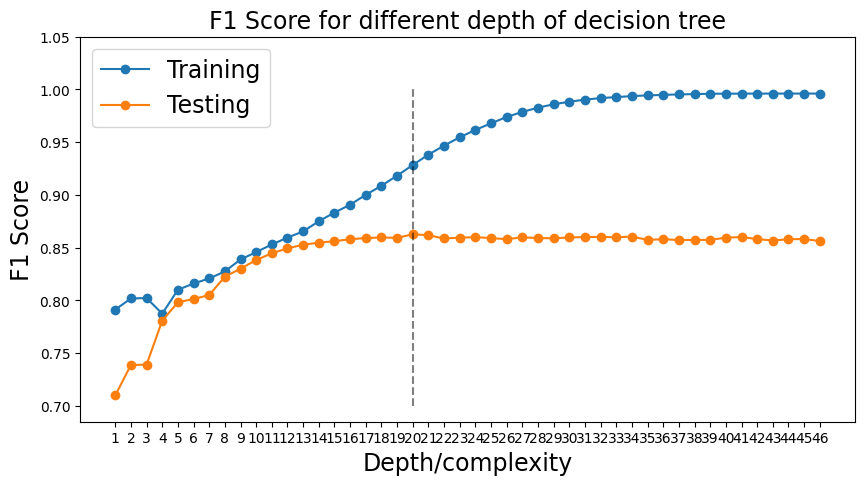

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline


train_scores = []
test_socres = []
for i in range(1, tree_clf.get_depth()+1):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=i).fit(X_train, y_train)
    
    # Computing f1_score in train set
    y_pred_train = model.predict(X_train)
    train_scores.append(f1_score(y_pred_train, y_train, average='weighted'))# f1_score on train set
  
    # Computing f1_score on test set
    y_pred = model.predict(X_test) # Making Predictions
    test_socres.append(f1_score(y_test, y_pred, average='weighted'))

max_test_score = np.argmax(test_socres) + 1
# Plot of depth vs accuracy
depth = tree_clf.get_depth()
plt.figure(figsize = (10,5))    
plt.plot(np.arange(1, depth+1, 1), train_scores, marker = 'o', label = 'Training')
plt.plot(np.arange(1, depth+1, 1), test_socres, marker = 'o', label = "Testing")
plt.plot([max_test_score,max_test_score], [0.7, 1.0], '--', color = 'black', alpha = 0.5)
plt.xlabel("Depth/complexity", fontsize = 17)
plt.ylabel("F1 Score", fontsize = 17)
plt.title("F1 Score for different depth of decision tree", fontsize = 17)
plt.xticks(np.arange(1, depth+1, 1)) 
plt.yticks(np.arange(0.7, 1.05, 0.05))
plt.legend(fontsize = 17)
plt.show()

### Analyze Model Performance by Tree Depth

- **Train decision trees** with varying depths and record F1 scores for each
- **Plot F1 score vs. tree depth** for both training and test sets
- Identifies the optimal tree depth for best generalization


Use the graph above to find out the least value for depth that yields the maximum f1-score on the test set and use it to set the `optimal_depth` variable.

In [21]:

optimal_depth = 20 

### Retrain Decision Tree with Optimal Depth

- **Train a new decision tree** using the selected optimal depth
- **Evaluate the F1 score** on the test set to confirm improved generalization

In [22]:
model = DecisionTreeClassifier(max_depth=optimal_depth, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test = f1_score(y_test, y_pred, average='weighted')

In [23]:
print("The MSE on test set after pruning = {}".format(round(test, 2)))

The MSE on test set after pruning = 0.86


### Review Pruned Regression Results

- **Print the MSE** on the test set after pruning
- Confirms the improvement in model performance due to early stopping

We see that by using early stopping, we have successfully improved the performance of our regression tree. The mean squared error has dropped from 5.86 to 4.62.  You may be able to further reduce the error by using cost-complexity pruning. However, as we have already used cost complexity pruning for classification, we won't play with it here. In your personal projects, you may play with both early stopping and pruning techniques to improve the performance and use the technique that gives better results.

## Final Summary

**Objective:**
- Predict guest booking cancellations and number of nights stayed using decision tree models.

**Steps Performed:**
- Loaded and cleaned the dataset, handling missing values and encoding categorical features
- Explored and visualized the data, including class imbalance
- Trained and evaluated decision tree classifiers, applying early stopping and cost complexity pruning
- Implemented entropy calculation from scratch and analyzed feature splits
- Built and optimized regression trees for predicting number of nights stayed

**Key Results:**
- Pruning and early stopping improved model generalization and reduced overfitting
- Custom entropy and weighted entropy calculations provided insight into feature selection
- Regression tree pruning reduced test MSE, confirming the value of model complexity control

**Next Steps:**
- Explore additional feature engineering or alternative models for further improvement
- Consider cross-validation for more robust model selection